# Double Trouble Pendulum

The `SwiftyTwoLinks` and `KotlyOtlyDobleDosLinks` apps, or _TwoLinks_ in short, embed a custom motion simulation that solves a systems of dynamic equations for a double pendulum.
This Jupyter Notebook demonstrates how those equations may be determined using the `sympy.physics.mechanics` toolkit.
Each step of the process including importing required modules, defining symbolic constants and variables, defining translational and rotational kinematics, deriving equations of motion, and simulating is included.
Furthermore, the `matplotlib` visualisation module is used to plot states, and create a plot that is used in the application icon.

## Preliminaries

The following modules are imported below, with their summary usage:
 - `sympy` for symbolic algebra
 - `sympy.physics.mechanics` for kinematics and equation of motion derivation
 - `scipy.integrate` for simulating the system of differential equations
 - `numpy` for array manipulation
 - `IPython.display` for rendering equations
 - `matplotlib.pyplot` for plotting

In [1]:
from sympy import *
from sympy.physics.mechanics import *
from scipy.integrate import solve_ivp
import numpy as np
from IPython.display import display, Latex
import matplotlib.pyplot as plt

The `mechanics_printing()` function is part of `sympy.physics.mechanics`. 
It reduces verbosity of the typeset equation by eliminating $(t)$ from time dependent symbolic terms, and representing time-derivatives by an overdot $\dot{(\, \,)}$ instead of $\partial / \partial t$.
Once it is called as a function, as it is below, these conventions will be followed anytime the `display` function is invoked.

In [2]:
mechanics_printing()

The function `dtex` is defined below to display LaTeX formatted equations with an equals sign separating left and right hand sides, either taking text-formatted inputs that the user defines, or symbolic equations derived by `sympy`.
Its intent is generally that the user may typeset a concise symbol on the left hand side, and the coinciding equation on the right.
It takes a variable number of arguments.

In [3]:
def dtex(*args):
    tex = ''
    for arg in args:
        if isinstance(arg, str):
            # Handle string arguments
            tex += f'${arg}$ $\, = \,$ '
        else:
            # Handle SymPy arguments
            tex += f'${mlatex(arg)}$ $\, = \,$ '
    
    # Trim off the last equals sign
    tex = tex[:-10]  
    display(Latex(tex))    

## Modeling

Below the requisite kinematics and equations of motion are developed symbolically. The derivation will use the dimensions, frames, and points defined in the graphic below, which will be described in further detail in the sections to follow.

![Model Diagram](https://radcli14.github.io/resume/images/twolinks.png)

### Symbols

For a double pendulum, we define two angles, $\theta_a$ and $\theta_b$, and two angular rates, $\omega_a$ and $\omega_b$, where the subscript $a$ represents the first link, and the subscript $b$ represents the second link.
In `sympy.physics.mechanics` we create the time-varying states using the `dynamicsymbols` function, with a list of symbolic terms in string form as the argument.
The vectors $\boldsymbol{q}$ and $\boldsymbol{u}$ represent generalized coordinates and generalized speeds, in radians and radians/sec, respectively.
For rendering symbols, LaTeX syntax may be used to specify greek characters, in this case `\theta` and `\omega` for $\theta$ and $\omega$, with the character `r` for "raw" placed in front of the string to prevent the `\` from acting as an escaping character.

In [4]:
q = dynamicsymbols(r'\theta_a \theta_b')
u = dynamicsymbols(r'\omega_a \omega_b')
dtex(r'\boldsymbol{q}', q)
dtex(r'\boldsymbol{u}', u)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Initial values are given to these coordinates and speeds to be used in the simulation that follows at the end of the notebook.
In this case, the setup is for the links to be initially held stationary at near vertical angle, then dropped with initially zero angular velocity.

In [5]:
q0 = np.deg2rad(44), np.deg2rad(44)
u0 = 0.0, 0.0

Several symbolic constants are defined for the link dimensions, mass, gravity, and time.
The $l_k$ symbols denote length, $m_k$ denote mass, and $I_k$ denote moment of inertia about the axis of rotation evaluated at the link center of gravity (CG).
The dimensions $x_a$ and $x_b$ represent distances from the centers of rotation for each link to their respective CG, and the dimension $x_p$ is the distance between the two centers of rotation.
Gravitational acceleration is given by $g_x$ and $g_y$ which are given relative to the fixed inertial frame.
Notably, these values are replaced in _TwoLinks_ by measurements from the device's internal accelerometer.

In [6]:
la, lb = symbols('l_a l_b')
ma, mb = symbols('m_a m_b')
Ia, Ib = symbols('I_a I_b')
xa, xb, xp = symbols('x_a x_b x_p')
gx, gy = symbols('g_x g_y')

Each constant defined above will be substituted with a numeric value prior to the simulation.
The `.subs` method that can be applied to any symbolic equation in `sympy` can take a dictionary as an argument, in which each key in the dictionary will be replaced with its corresponding value.
Note that the keys themselves are the symbols defined above.

In [7]:
constants = {
    la: 0.2,
    lb: 0.15,
    ma: 0.1,
    mb: 0.1,
    Ia: 5e-6,
    Ib: 5e-6,
    xa: 0.1,
    xb: 0.075,
    xp: 0.2,
    gy: -9.8,
    gx: 0.0
}

### Kinematic Equations

`sympy` convention for solvers in the case of systems of equations is to rearrange such that you have vector of equations set equal to zero.
For dynamics system modeling, the implementation of Kane's method requires that such a condition is defined that relates the generalized coordinates to the generalized speeds.
In this case, the generalized speeds, $\omega_k$, are simply the derivative with respect to time of the generalized coordinates, or $\dot{\omega}_k$.
These are referred to as the kinematic equations, which are defined below using a Python list comprehension, with a loop defined over the lists of coordinates and speeds, with the `zip` function used to specify that the two lists will be looped simultaneously.

In [8]:
kd = [speed - diff(coord) for coord, speed in zip(q, u)]
dtex(Matrix([[0], [0]]), Matrix(kd))

<IPython.core.display.Latex object>

### Frames

The inertial reference frame is defined from which all subsequent frames will be referenced.
We initialize it using a `ReferenceFrame` object, which is given the name $N$.
The second, optional argument, provides LaTeX-formatted names for the basis vectors, in this case $\hat{\mathbf{x}}$, $\hat{\mathbf{y}}$, and $\hat{\mathbf{z}}$.

In [9]:
latexs = [r'\hat{\boldsymbol{' + ax + '}}' for ax in 'xyz']
inertial = ReferenceFrame('N', latexs=latexs)

The inner frame, which is aligned with the first link, is initialized using the `.orientnew` method of the inertial frame.
The first argument is the name of the inner frame, $A$. The second argument defines the type of rotation to be applied, in this case `'axis'` which denotes a single angular rotation about a specified vector.
The list that follows contains the angle $\theta_0$ which defines rotation about the $\hat{\mathbf{z}}$ axis.
Once initialized, the $A$ frame will be defined by unit vectors $\hat{\mathbf{a}}_x$, $\hat{\mathbf{a}}_y$, and $\hat{\mathbf{a}}_z$, which when expressed in the inertial frame are:

In [10]:
innerFrame = inertial.orientnew('A', 'axis', [q[0], inertial.z])
for axis in (innerFrame.x, innerFrame.y, innerFrame.z):
    dtex(axis, axis.express(inertial))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

These can similarly be expressed as the direction cosine matrix (DCM), using the `dcm` method with the inertial frame as the argument, yielding:

In [11]:
dtex(r'\mathbf{R}_A', innerFrame.dcm(inertial))

<IPython.core.display.Latex object>

Finally, a vector representing the angular velocity of the inner frame must be defined.
This is done with the `.set_ang_vel` method. The first argument to this method is the inertial frame, which the angular velocity is defined relative to, and the angular velocity vector.
In this case using the generalized speed term $\omega_a$ to replace the derivative of the generalized coordinate, the angular velocity vector:

In [12]:
innerFrame.set_ang_vel(inertial, u[0] * inertial.z)
dtex(r'\mathbf{\omega}_A', diff(q[0]) * inertial.z, innerFrame.ang_vel_in(inertial))

<IPython.core.display.Latex object>

The outer frame, with the name $B$, is defined in the same manner as the inner frame, in this case using the generalized speed $\theta_b$ for its angle relative to the inertial frame, and the generalized speed $\omega_b$ for its angular rate.

In [13]:
outerFrame = inertial.orientnew('B', 'axis', [q[1], inertial.z])
outerFrame.set_ang_vel(inertial, u[1] * inertial.z)

The DCM for the outer frame relative to inertial frame, $\mathbf{R}_B$, takes the same form as $\mathbf{R}_A$, substituting $\theta_b$ for $\theta_a$:

In [14]:
dtex(r'\mathbf{R}_B', outerFrame.dcm(inertial))

<IPython.core.display.Latex object>

Likewise, the angular velocity vector for the outer frame relative to inertial frame, $\mathbf{\omega}_B$, takes the same form as $\mathbf{\omega}_A$, substituting $\omega_b$ for $\omega_a$:

In [15]:
dtex(r'\mathbf{\omega}_B', diff(q[1]) * inertial.z, outerFrame.ang_vel_in(inertial))

<IPython.core.display.Latex object>

### Points

The origin represents a stationary point from which all subsequent points are defined.
Here, it is initialized as a `Point` object with the argument specifying its name, $O$.
The `.set_vel` method is used to specify it as having zero velocity in the inertial frame.
Because this method requires a vector input and will throw an error if provided an integer zero, the second argument `Vector(0)` creates a zero vector.

In [16]:
origin = Point('O')
origin.set_vel(inertial, Vector(0))

The position of the CG for the first link is the point $a$.
This point is initialized using the `.locatenew` method, with name as the first argument, and a vector as the second argument, to give the position vector of $a$ relative to the origin:

In [17]:
innerCG = origin.locatenew('a', xa * innerFrame.x)
dtex(r'\mathbf{r}_a', innerCG.pos_from(origin), 
     innerCG.pos_from(origin).express(inertial))

<IPython.core.display.Latex object>

To specify the velocity of $a$ we call the `.v2pt_theory` method with the origin point, inertial frame, and inner frame as arguments.
The so-called "two-point theory" for velocity of $a$ solves the equation
$\dot{\mathbf{r}}_a = \dot{\mathbf{r}}_O + \mathbf{\omega_A} \times \mathbf{r}_{a/O}$, 
where $\dot{\mathbf{r}}_a$ is the velocity of $a$ in the inertial frame, 
$\dot{\mathbf{r}}_O = \mathbf{O}$ is the velocity of the origin, 
and $\mathbf{r}_{a/O}$ is the distance measured from the origin to $a$. 
Calling `.v2pt_theory` will also internally set the velocity vector of the object:

In [18]:
innerCG.v2pt_theory(origin, inertial, innerFrame)
dtex(r'\dot{\mathbf{r}}_a', innerCG.vel(inertial))

<IPython.core.display.Latex object>

We may also at this point obtain the acceleration vector, with centripetal and tangential terms:

In [19]:
dtex(r'\ddot{\mathbf{r}}_a', innerCG.acc(inertial))

<IPython.core.display.Latex object>

The pivot point about which the outer link will rotate is created in much the same manner as $a$, in this case substituting the dimension $x_p$ in place of $x_a$.
Its position, velocity, and acceleration vectors are:

In [20]:
outerPivot = origin.locatenew('p', xp * innerFrame.x)
outerPivot.v2pt_theory(origin, inertial, innerFrame)
dtex(r'\mathbf{r}_p', outerPivot.pos_from(origin))
dtex(r'\dot{\mathbf{r}}_p', outerPivot.vel(inertial))
dtex(r'\ddot{\mathbf{r}}_p', outerPivot.acc(inertial))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

The CG of the second link is also created in a similar manner, however, where $a$ and $p$ were each defined relative to the origin, the outer link CG is defined relative to $p$.
Its position, velocity, and acceleration vectors are:

In [21]:
outerCG = outerPivot.locatenew('b', xb * outerFrame.x)
outerCG.v2pt_theory(outerPivot, inertial, outerFrame)
dtex(r'\mathbf{r}_b', outerCG.pos_from(origin))
dtex(r'\dot{\mathbf{r}}_b', outerCG.vel(inertial))
dtex(r'\ddot{\mathbf{r}}_b', outerCG.acc(inertial))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Two additional points, $a^\prime$ and $b^\prime$, are defined that represent the ends of the two links.
These are initialized at locations that are one half length of the respective links from the link CG, and are not required to define the dynamics model, but are used at the end of this notebook to plot the icon graphic.

In [22]:
innerEnd = innerCG.locatenew('a^\prime', 0.5 * la * innerFrame.x)
outerEnd = outerCG.locatenew('b^\prime', 0.5 * lb * outerFrame.x)

### Bodies

A rigid body representing the first link is created as a `Body` object.
The required arguments are a name, the point $a$ defining the body's CG, the symbolic mass $m_a$, the frame $A$ defining orientation, and a central inertia.
The latter requires a so-called "inertia tuple" which is created with the `inertia` helper function, which takes the $A$ reference frame, and inertias defined about the basis vectors of the frame.
Since motion is restricted to be solely about the $\hat{\mathbf{z}} = \hat{\mathbf{a}}_z$ axis, we only need to provide the inertia $I_a$, which is defined about the link CG.

In [23]:
innerBody = Body(
    'A', 
    masscenter=innerCG, 
    mass=ma, 
    frame=innerFrame, 
    central_inertia=inertia(innerFrame, 0, 0, Ia)
)

The same approach is used to define the second link, in this case providing the point $b$, symbolic mass $m_b$, $B$ reference frame, and inertia defined about $b$ in the $B$ frame.

In [24]:
outerBody = Body(
    'B', 
    masscenter=outerCG, 
    mass=mb, 
    frame=outerFrame, 
    central_inertia=inertia(outerFrame, 0, 0, Ib)
)

Equation of motions derived in latter sections require the bodies to be provided as an iterable, as in the tuple below.

In [25]:
bodies = innerBody, outerBody

### Gravitational Load

The gravitational acceleration vector is a combination of $g_x$ in the $\hat{\mathbf{x}}$ direction, and $g_y$ in the $\hat{\mathbf{y}}$ direction, respectively, or:

In [26]:
gvector = gx * inertial.x + gy * inertial.y
dtex(r'\mathbf{g}', gvector)

<IPython.core.display.Latex object>

Gravitational force acts on the CG of the inner panel, with magnitude equal to its mass times gravitational acceleration, or:

In [27]:
innerLoad = innerBody.masscenter, innerBody.mass * gvector
dtex(r'\mathbf{F}_a', innerLoad[1])

<IPython.core.display.Latex object>

Similarly for the outer link:

In [28]:
outerLoad = outerBody.masscenter, outerBody.mass * gvector
dtex(r'\mathbf{F}_b', outerLoad[1])

<IPython.core.display.Latex object>

The expected form for the loads to be provided to the equation of motion solver is an iterable-of-iterables.
For each of the internal iterables, the first entry is the point or frame on which the load is applied, and the second entry is the load vector.

In [29]:
loads = innerLoad, outerLoad

### Equations of Motion

A `KanesMethod` object is initialized which contains the internal methods to derive equations of motion using, you guessed it, Kane's method.
It is initialized using the inertial frame (in which the equations are derived), and iterables for generalized coordinates, generalized speeds, and kinematic equations.
Each of these have already been defined above.

In [30]:
kane = KanesMethod(inertial, q, u, kd)

To derive equations, we must call the `.kanes_equations` methods, with the bodies and loads defined above as its arguments.
Importantly, the mass matrix and forcing vector will not be available until _after_ this method is called.
The output of the method are the external force vector $\mathbf{F}_r$ and internal force vector $\mathbf{F}_r^*$. 
For the double pendulum, these vectors in their simplified form are:

In [31]:
fr, frstar = kane.kanes_equations(bodies, loads)
dtex(r'\mathbf{F}_r', simplify(fr))
dtex(r'\mathbf{F}_R^*', simplify(frstar))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

For simulation purposes, we obtain the "full" mass matrix and forcing vectors, which for an equation
$\mathbf{M}\dot{\mathbf{x}} = \mathbf{F}$, 
with the state vector $\mathbf{x} = \left( \theta_a, \theta_b, \omega_a, \omega_b \right)^T$ containing both generalized coordinates and generalized speeds.
In this case, the mass matrix is:

In [32]:
M = simplify(kane.mass_matrix_full)
dtex(r'\mathbf{M}', M)

<IPython.core.display.Latex object>

The forcing vector is:

In [33]:
F = simplify(kane.forcing_full)
dtex(r'\mathbf{F}', F)

<IPython.core.display.Latex object>

## Simulation

The double pendulum equations are simulated using an adaptive Runge-Kutta 4/5 (RK45) method, implemented in the `scipy.integrate.solve_ivp` function.
Prior to calling this function, the equations of motion must be converted to a function of the form $f(t, x)$, where $t$ is time, and $x$ is a vector of current state values.
The resulting states as a function of time are plotted, and then the position trajectories are used to form a graphic used in the _TwoLinks_ icon.

### Initial Value Problem (IVP)

Two functions are generated to represent the mass matrix, and forcing vector, respectively.
To be callable with solely the state vector $x$ as an input, first the `.subs` method is called on the symbolic properties with the `constants` dictionary as the argument, which will substitute numeric values into the equations.
Then, the `lambdify` function is called, with the state vector and equations with numeric values as its arguments, which will return a callable function that takes a vector of numeric state values.

In [34]:
massFunction = lambdify(q+u, M.subs(constants))
forcingFunction = lambdify(q+u, F.subs(constants))

An ordinary differential equation (ODE) function is defined which takes time and state as its inputs.
Internal to the function, the mass matrix and forcing vector are calculated using the functions determined above using `lambdify`.
Then, the derivatives of the state vector with respect to time are determined using the `numpy.linalg.solve` function.
Note, prior to solving, the force is "flattened," which reduces it from a 2-dimensional array to 1-dimensional, as required by the solver.

In [35]:
def ode(t, x):
  mass = massFunction(*x)
  force = forcingFunction(*x).flatten()
  return np.linalg.solve(mass, force)

### Solution

The ODE is solved (integrated) using the `solve_ivp` function, where the first argument is the function itself, second is the time span, and third is an iterable of initial states.
An optional, relativel tolerance (`rtol`) is used to improve the accuracy of the numerically integrated equation.
In this case, this option is invoke to improve the "smoothness" of the simulated states, which improves the visual quality.

In [36]:
sol = solve_ivp(ode, [0, 1.75], q0+u0, rtol=1e-9)

### Plot Angles and Rates

State variables in $\boldsymbol{q}$ and $\boldsymbol{u}$ are plotted as a function of time using the `matplotlib.pyplot` library.
Slice indexing of the `numpy` arrays is used to partition the simulated states, in this case with `sol.y[:2]` giving the generalized coordinates, and `sol.y[2:]` giving the generalized speeds.

In [37]:
qsol = sol.y[:2].transpose()
usol = sol.y[2:].transpose()

Legends are created using a list comprehension taking the name provided to the symbolic form of the states, where placing `f` in front of the string specifies that the variable inside the curly brackets, `{ . }`, is converted to string.
Surrounding the string with dollar signs, `$ . $`, will invoke the LaTeX interpreter when generating the legend.

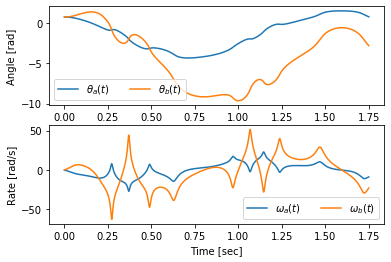

In [38]:
plt.subplot(2, 1, 1);
plt.plot(sol.t, qsol);
plt.ylabel('Angle [rad]');
plt.legend([f'${angle}$' for angle in q], ncol=2);

plt.subplot(2, 1, 2);
plt.plot(sol.t, usol);
plt.xlabel('Time [sec]')
plt.ylabel('Rate [rad/s]');
plt.legend([f'${rate}$' for rate in u], ncol=2);

### Plot X-Y Position

The _TwoLinks_ icon contains a trajectory plot generated from the positions of the ends of the two links , $a^\prime$ and $b^\prime$, as a function of time.
Recall that during the modeling section, two points were created representing the end of the two links.
We need to create functions from which we can determine numeric values for these positions given current values of the generalized coordinates.
First, we obtain a matrix form of the positions in inertial coordinates.

In [39]:
innerPosMat = innerEnd.pos_from(origin).to_matrix(inertial)
outerPosMat = outerEnd.pos_from(origin).to_matrix(inertial)
dtex(r'\boldsymbol{r}_{a^\prime}', innerPosMat)
dtex(r'\boldsymbol{r}_{b^\prime}', outerPosMat)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

From the matrix equation, we create a callable function using `lambdify`, with the first argument containing the generalized coordinates, and second the matrix equation.
The dictionary containing constants is substituted such that the function will only depend on the symbolic coordinates.

In [40]:
innerPosFcn = lambdify(q, innerPosMat.subs(constants))
outerPosFcn = lambdify(q, outerPosMat.subs(constants))

A list comprehension is used to obtain the positions at each time step contained in the IVP solution.
These are subsequently converted to a `numpy` array for convenience in plotting.
As before, the solution is flattened at each time step to ensure it is 1-dimensional.

In [41]:
innerPos = np.array([innerPosFcn(*q).flatten() for q in qsol])
outerPos = np.array([outerPosFcn(*q).flatten() for q in qsol])

These arrays are plotted to create an initial version of the app icon.
The figure is specified to be square, and with 80 dots per inch (DPI), yielding a 512 x 512 square.
The first call to `matplotlib.pyplot.plot` displays the inner link position, which traces a circle, and is intended to represent an outline of the shadow of the moon.
The call to `matplotlib.pyplot.scatter` displays the outer link position, which traces out a more complex geometry, and varies in color over time using the `'rainbow'` colormap.
Subsequent lines set the shape of the figure, remove the axis ticks, and set the background color to black.

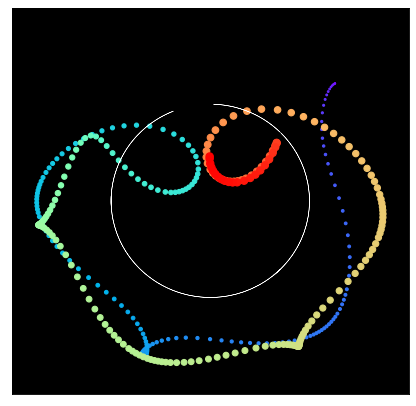

In [42]:
plt.figure(figsize=(6.4, 6.4), dpi=80)
plt.plot(innerPos[:, 0], innerPos[:, 1], 'w', linewidth=0.5);
plt.scatter(outerPos[:, 0], outerPos[:, 1], 
            s=8*sol.t*3.14, c=sol.t, cmap='rainbow');
plt.xlim([-0.4, 0.4]);
plt.ylim([-0.4, 0.4]);
plt.xticks(ticks=[]);
plt.yticks(ticks=[]);
ax = plt.gca();
ax.set_facecolor((0.0, 0.0, 0.0));

Lastly, the graphic is saved to a PDF file.
I have used [Inkscape](https://inkscape.org/) to import this PDF, and further manipulate to create the final icon that I use with the app.

In [43]:
plt.savefig('links.pdf');

<Figure size 432x288 with 0 Axes>

## Conclusion
This notebook demonstrates how to use `sympy.physics.mechanics` to determine equations of motion for a double pendulum.
The mobile apps `SwiftyTwoLinks` and `KotlyOtlyDobleDosLinks` have used these equations to create real-time simulation code in Swift and Kotlin.
As an added bonus, the icon for the apps is generated in the Jupyter notebook.